# Playing Card Detection
[Paper Link](https://web.stanford.edu/class/ee368/Project_Winter_1819/Reports/snyder.pdf)

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
images_folder = 'Images'
test_image = 'Images/cards1.png'

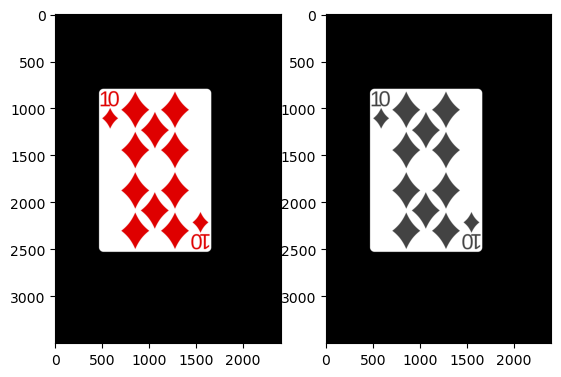

In [3]:
card = cv2.imread(test_image)
card = cv2.cvtColor(card, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(card, cv2.COLOR_RGB2GRAY)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(card)
axes[1].imshow(gray, cmap='gray')

## Template Matching

#### 1 - Card Detection  
https://stackoverflow.com/questions/62274412/cv2-approxpolydp-cv2-arclength-how-these-works

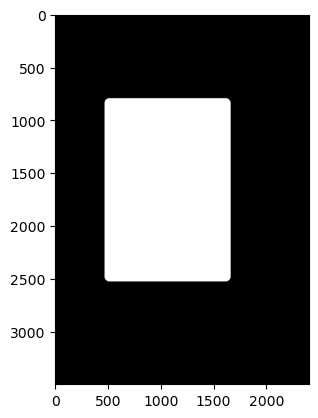

In [4]:

def get_card_contour(card, contours, area_threshold=1500000):
    area_threshold = card.shape[0] * card.shape[1] * 0.10 # the area of the contour should atleast be 10% of the image area.
    card_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > area_threshold:
            perimeter = cv2.arcLength(contour, True) #??
            polygon = cv2.approxPolyDP(contour, 0.04*perimeter, True) #??
            if len(polygon) == 4:
                card_contours.append(contour)
    return card_contours

def detect_card(image):
    threshold = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, threshold = cv2.threshold(threshold, 127, 255, cv2.THRESH_BINARY) # binarize the image
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # get the contours

    card_contour = get_card_contour(image, contours=contours)
    card_detected = threshold.copy()
    cv2.drawContours(card_detected, [card_contour[0]], -1, (255), thickness=cv2.FILLED)
    return card_detected, threshold, card_contour

card_detected, threshold, card_contour = detect_card(card)
plt.imshow(card_detected, cmap='gray')

### 2. Corner Finding

##### 2.1 - Canny Edge Detection & Hough Transform - To Find Lines

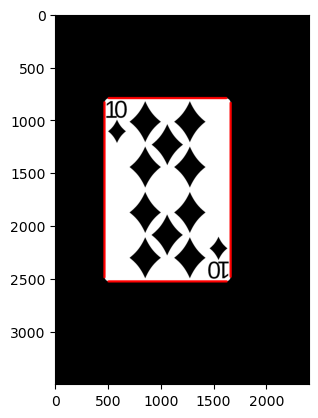

In [5]:
def convert_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

def find_lines(image):
    edges = cv2.Canny(image, 50, 150) # canny edge detector
    lines_xy = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=200) ### Hough Transform  - To Find Lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=200) # hough lines
    
    rgb_image = convert_to_rgb(image)
    for points in lines_xy:
        x1, y1, x2, y2 = points[0]
        cv2.line(rgb_image, (x1, y1), (x2, y2), (255, 0, 0), 20)
    return lines, rgb_image

lines, corner_image = find_lines(threshold)
plt.imshow(corner_image)

##### 2.2 - Find The Corners

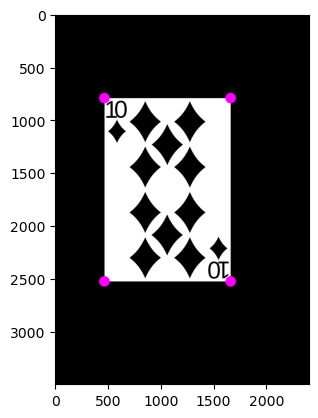

In [6]:
from itertools import combinations

def find_corners(lines):
    two_lines = list(combinations(lines, 2)) # a cartesian product of lines, taken two at a time
    corners = []
    for two_line in two_lines:
        line_a, line_b = two_line
        r_a, theta_a, r_b, theta_b = *line_a[0], *line_b[0] # r and theta - line in polar form
        cos_a, sin_a, cos_b, sin_b = np.cos(theta_a), np.sin(theta_a), np.cos(theta_b), np.sin(theta_b)
        determinative = cos_a * sin_b - sin_a * cos_b
        
        if determinative != 0: # lines are not parallel, parallel lines wont meet
            x = int((sin_b * r_a - sin_a * r_b) / determinative)
            y = int((-cos_b * r_a + cos_a * r_b) / determinative)
            corners.append((x, y))
    return corners

def mark_corners(image, corners):
    for corner in corners:
        cv2.circle(image, corner, 50, (255, 0, 255), -1)
    return image

corners = find_corners(lines)
corner_image = mark_corners(convert_to_rgb(threshold), corners)
plt.imshow(corner_image)

In [7]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

cx, cy, w, h = cv2.boundingRect(card_contour[0])
card_region = threshold[cy: cy + h, cx: cx + w]
card_corners = [[0, 0], [w, 0], [0, h], [w, h]]

### 3) Corner Arrangement

In [8]:
def find_first_corner(card_corners, card_symbols_contour):
    min_corner, min_corner_distance = None, 1e10
    for contour in card_symbols_contour[1:]:
        cx, cy, _, _ = cv2.boundingRect(contour)
        for corner in card_corners:
            distance = euclidean_distance(cx, cy, *corner)
            if distance < min_corner_distance:
                min_corner, min_corner_distance = corner, distance
    return min_corner

def sort_corners(card_region, card_corners):
    card_corners_2 = card_corners.copy() # check pass by reference

    card_symbols_contour, _ = cv2.findContours(card_region, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # contour of symbols inside the card region

    # Find the corner which is more close to a contour/ symbol. 
    # The Top-Left/ Bottom-Right corner would be the least distant for a standard deck of cards
    min_corner = find_first_corner(card_corners_2, card_symbols_contour)
    
    sorted_corners = []
    # check the distance between previously calculated minimum corner and the other 
    # corners and remove the least distant corner after adding it to the sorted list. 
    while True:
        # print(min_corner, corner)
        corner_to_corner_distance = np.array([euclidean_distance(*min_corner, *corner) for corner in card_corners_2])
        min_id = np.argsort(corner_to_corner_distance)[0] # index of corner with the minimum corner to corner distance
        min_corner = card_corners_2[min_id]
        sorted_corners.append(min_corner) # add the minimum corner to sorted list
        del card_corners_2[min_id] # remove the corner with minimum distance from the corners list.
        if len(card_corners_2) <1: # terminate after processing the last corner
            break
    
    return sorted_corners

sorted_corners = sort_corners(card_region, card_corners)

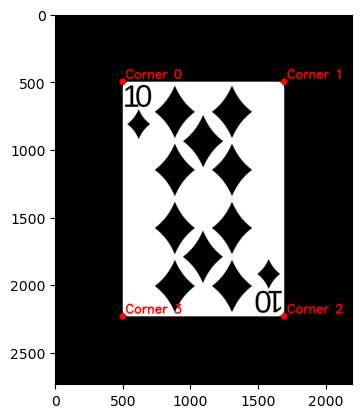

In [89]:
def mark_sorted_corners(image, sorted_corners, padding=0):
    font, font_scale, font_thickness, font_color = cv2.FONT_HERSHEY_SIMPLEX, 3, 10, (255, 0, 0) # creating font

    for id, corner in enumerate(sorted_corners):
        cv2.circle(image, (corner[0]+padding, corner[1]+padding), 25, (255, 0, 0), -1) # draw a circle at corner
        cv2.putText(image, f'Corner {id}', (corner[0]+padding+20, corner[1]+padding-25), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
    return image

def pad_image(image, padding):
    return cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=(0, 0, 0))

padding = 500
padded_image = convert_to_rgb(pad_image(card_region, padding))
sorted_corners_image = mark_sorted_corners(padded_image, sorted_corners, padding)
plt.imshow(sorted_corners_image)

### 4 - Transform creation

In [72]:
def homographic_tranform(template, target):
    H, _ = cv2.findHomography(np.array(template[-1]), np.array(target[-1]))

    # Warp the first image onto the second image using the homography matrix
    return cv2.warpPerspective(template[2], H, (target[2].shape[1], target[2].shape[0]))

### 5 - Scoring

In [81]:
def get_corner(image):
    card_detected, threshold, card_contour = detect_card(image)
    lines, corner_image = find_lines(threshold)

    cx, cy, w, h = cv2.boundingRect(card_contour[0])
    card_region = threshold[cy: cy + h, cx: cx + w]
    card_corners = [[0, 0], [w, 0], [0, h], [w, h]]
    sorted_corners = sort_corners(card_region, card_corners)
    return card_detected, threshold, card_region, sorted_corners

def rotate_180(image):
    return cv2.rotate(image, cv2.ROTATE_180)

card1 = cv2.imread('Images/cards1.png')
card2 = cv2.imread('Images/cards4.png')
card3 = cv2.imread('Images/cards5.png')
card2_r, card3_r = rotate_180(card2), rotate_180(card3), 

card1_corners = get_corner(card1)
card2_corners, card2_r_corners = get_corner(card2), get_corner(card2_r)
card3_corners, card3_r_corners = get_corner(card3), get_corner(card3_r)


In [82]:
def compute_ssd_score(template, target):
    transform_result = homographic_tranform(template, target)
    return np.round(np.sqrt(np.sum((np.array(target[2]) - np.array(transform_result))**2)), 2)

ssd_score12 = compute_ssd_score(card1_corners, card2_corners)
ssd_score13 = compute_ssd_score(card1_corners, card3_corners)
ssd_score12_r = compute_ssd_score(card1_corners, card2_r_corners)
ssd_score13_r = compute_ssd_score(card1_corners, card3_r_corners)

ssd_score12 = min(ssd_score12, ssd_score12_r)
ssd_score13 = min(ssd_score13, ssd_score13_r)

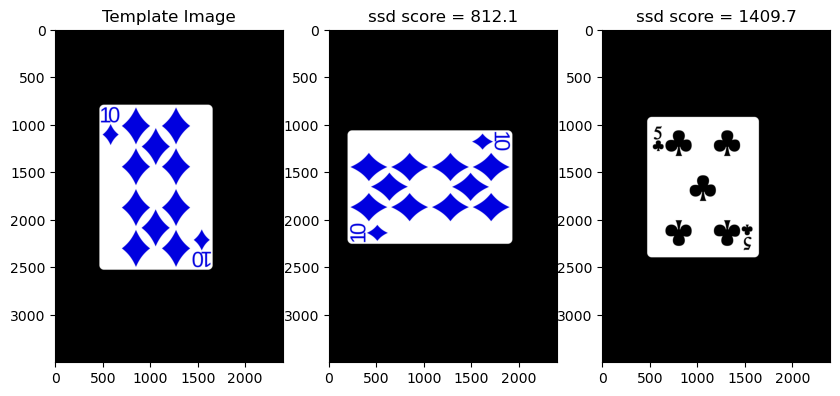

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(card1)
axes[0].set_title('Template Image')
axes[1].imshow(card2)
axes[1].set_title(f'ssd score = {ssd_score12}')
axes[2].imshow(card3)
axes[2].set_title(f'ssd score = {ssd_score13}');